Geometry mapping saved to geometry.pkl


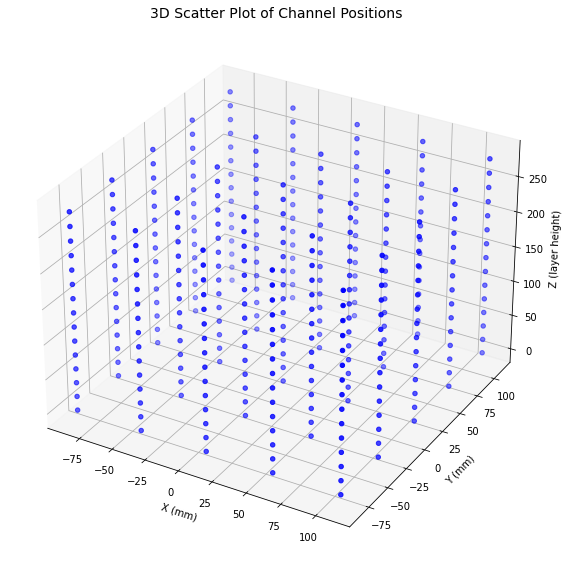

In [3]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# -------------------------------------------------------------------------------
#1. Set up for data
# -------------------------------------------------------------------------------

Data = {
    "Ch#": [],
    "Layer": [],
    "Assigned Slot": [],
    "x": [],
    "y": [],
    "z": [],
    "Position": []
} #Uses a dictionary Were the values will be saved (Ch# includes CAEN unit)

Channel_Numbers = [f"{board}-{ch_index}" for board in range(1, 7) for ch_index in range(64)]
#Sets up the range (6 units that has 63 channels)

# -------------------------------------------------------------------------------
#2. Coords set up
# -------------------------------------------------------------------------------

# X, Y grid used in the 3D plot
x_values = [109.800, 61.0, 12.2, -36.6, -85.4]
y_values = [109.800, 61.0, 12.2, -36.6, -85.4]

# Create all coordinate combinations
xy_pairs = list(itertools.product(x_values, y_values))

# Repeat Z-layers based on 15-layer system (like in tile code)
layer_mapping = {
    0: 0, 1: 20, 2: 40, 3: 60, 4: 80,
    5: 100, 6: 120, 7: 140, 8: 160, 9: 180,
    10: 200, 11: 220, 12: 240, 13: 260, 14: 280
}

# Fill positions for each channel, cycle through xy_pairs and layers for layout

lower_layer_mapping = {
    1: 0,
    2: 1,
    3: 5,
    4: 7,
    5: 10,
    6: 12
}
upper_layer_mapping = {
    1: 2,
    2: 3,
    3: 6,
    4: 8,
    5: 11,
    6: 13
}

position_cycle = itertools.cycle(xy_pairs)
position_values = {}

for ch in Channel_Numbers:
    board, ch_index = map(int, ch.split('-'))

    # Match the Z-layer based on tile positioning
    if 0 <= ch_index <= 12:
        layer = lower_layer_mapping[board]
    elif 13 <= ch_index <= 24:
        layer = lower_layer_mapping[board]
    elif 25 <= ch_index <= 37:
        layer = upper_layer_mapping[board]
    elif 38 <= ch_index <= 49:
        layer = upper_layer_mapping[board]
    elif 50 <= ch_index <= 63:
        if board in [1, 2]:
            layer = 4
        elif board in [3, 4]:
            layer = 9
        elif board in [5, 6]:
            layer = 14
    else:
        layer = 0  # default fallback

    x, y = next(position_cycle)
    z = layer_mapping[layer]
    position_values[ch] = (x, y, z)

# -------------------------------------------------------------------------------
#4. Board orientation
# -------------------------------------------------------------------------------

def board_position(board):
    return "Odd" if board % 2 == 1 else "Even"
#Checks to see if the board is in the top left or bottom right corner

# -------------------------------------------------------------------------------
#5. the meat of the code (Slots, layer and coords)
# -------------------------------------------------------------------------------

layer_counts = {i: 0 for i in range(15)}  # Track how many channels are assigned per layer
max_per_layer = 25

for ch in Channel_Numbers:
    #Get coords from other function
    x, y, z = position_values[ch]

    # Parse board and channel index from "board-ch_index"
    board, ch_index = map(int, ch.split('-'))

    # For channels 0-49, assign Assigned Slot and layer based on index ranges.
    if 0 <= ch_index <= 12:
        assigned_slot = "A"
        layer = lower_layer_mapping[board]
    elif 13 <= ch_index <= 24:
        assigned_slot = "B"
        layer = lower_layer_mapping[board]
    elif 25 <= ch_index <= 37:
        assigned_slot = "A"
        layer = upper_layer_mapping[board]
    elif 38 <= ch_index <= 49:
        assigned_slot = "B"
        layer = upper_layer_mapping[board]
    # For channels 50-63, use board parity to assign the slot:
    elif 50 <= ch_index <= 63:
        if board % 2 == 1:
            assigned_slot = "A"
        else:
            assigned_slot = "B"
        # And assign layer based on board group:
        if board in [1, 2]:
            layer = 4
        elif board in [3, 4]:
            layer = 9
        elif board in [5, 6]:
            layer = 14
    else:
        continue
    if layer_counts[layer] >= max_per_layer:
        continue

    layer_counts[layer] += 1

    x, y, z = position_values[ch]
    pos = board_position(board)

    # Add data to the dictionary
    Data["Ch#"].append((64*(board-1))+ch_index)
    Data["Assigned Slot"].append(assigned_slot)
    Data["Layer"].append(layer)
    Data["x"].append(x)
    Data["y"].append(y)
    Data["z"].append(z)
    Data["Position"].append(pos)

# -------------------------------------------------------------------------------
# 6. Create DataFrame and Save It as a Pickle File
# -------------------------------------------------------------------------------

Geometry_df = pd.DataFrame(Data)
Geometry_df.to_pickle("geometry.pkl")
print("Geometry mapping saved to geometry.pkl")

# -------------------------------------------------------------------------------
#7 Create a plot using the x y and z values
#--------------------------------------------------------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(Geometry_df["x"], Geometry_df["y"], Geometry_df["z"], c='blue', marker='o', s=20)

# Labels and formatting
ax.set_title("3D Scatter Plot of Channel Positions", fontsize=14)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (layer height)")

plt.tight_layout()
plt.show()

In [66]:
import pandas as pd

# Load the pickle file
Geometry_df = pd.read_pickle("geometry.pkl")

# Print the entire DataFrame without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width for better visibility

print(Geometry_df)

      Ch#  Layer Assigned Slot      x      y    z Position
0     1-0      0             A  109.8  109.8    0      Odd
1     1-1      0             A  109.8   61.0    0      Odd
2     1-2      0             A  109.8   12.2    0      Odd
3     1-3      0             A  109.8  -36.6    0      Odd
4     1-4      0             A  109.8  -85.4    0      Odd
5     1-5      0             A   61.0  109.8    0      Odd
6     1-6      0             A   61.0   61.0    0      Odd
7     1-7      0             A   61.0   12.2    0      Odd
8     1-8      0             A   61.0  -36.6    0      Odd
9     1-9      0             A   61.0  -85.4    0      Odd
10   1-10      0             A   12.2  109.8    0      Odd
11   1-11      0             A   12.2   61.0    0      Odd
12   1-12      0             A   12.2   12.2    0      Odd
13   1-13      0             B   12.2  -36.6    0      Odd
14   1-14      0             B   12.2  -85.4    0      Odd
15   1-15      0             B  -36.6  109.8    0      O

Geometry mapping saved to geometry.pkl


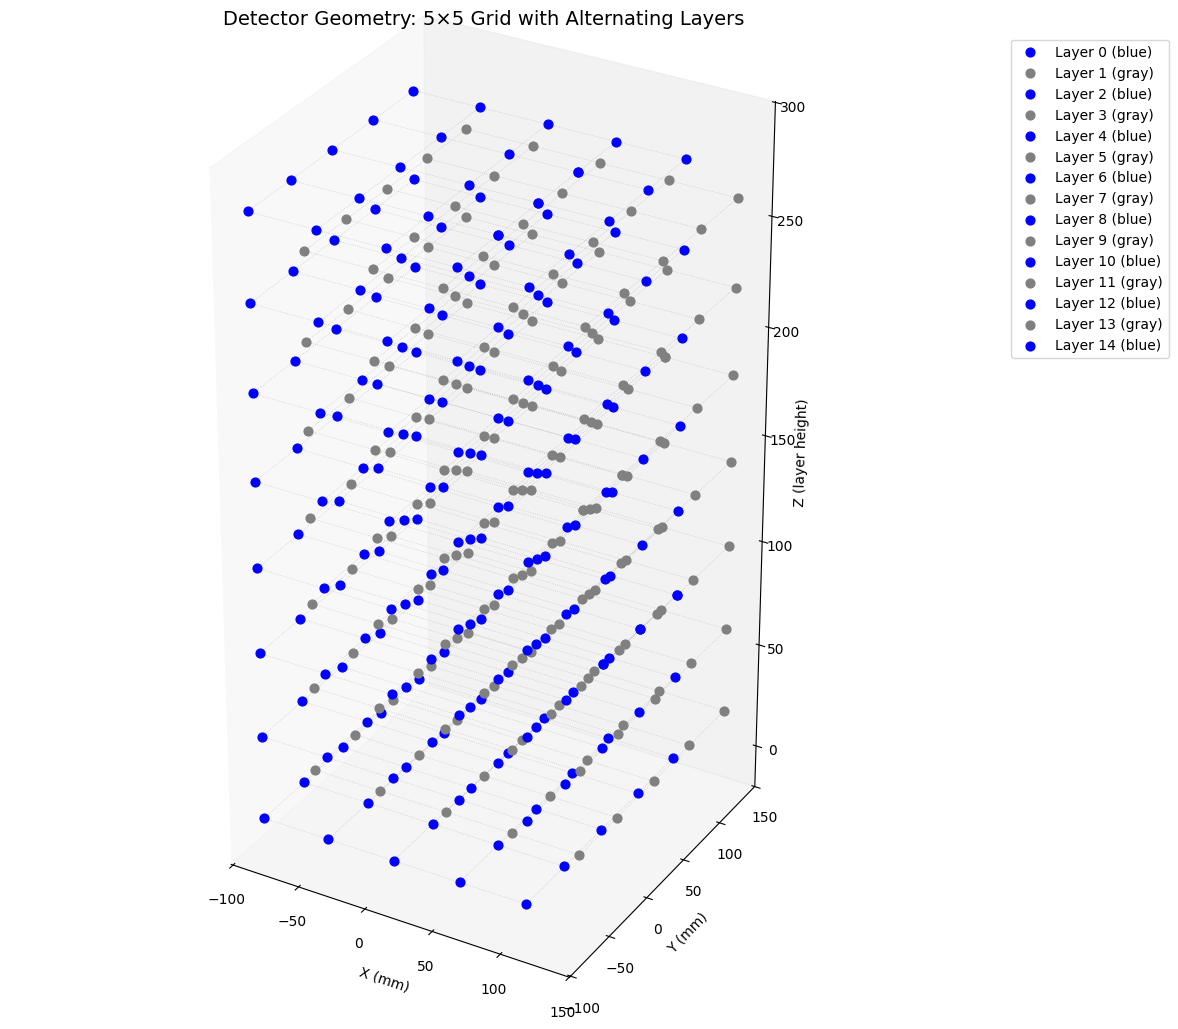

In [60]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# -------------------------------------------------------------------------------
#1. Set up for data
# -------------------------------------------------------------------------------

Data = {
    "Ch#": [],
    "Layer": [],
    "Assigned Slot": [],
    "x": [],
    "y": [],
    "z": [],
    "Position": []
} #Uses a dictionary Were the values will be saved (Ch# includes CAEN unit)

Channel_Numbers = [f"{board}-{ch_index}" for board in range(1, 7) for ch_index in range(64)]
#Sets up the range (6 units that has 63 channels)

# -------------------------------------------------------------------------------
#2. Coords set up
# -------------------------------------------------------------------------------

# X, Y grid used in the 3D plot
x_values = [109.800, 61.0, 12.2, -36.6, -85.4]
y_values = [109.800, 61.0, 12.2, -36.6, -85.4]

# Create all coordinate combinations
xy_pairs = list(itertools.product(x_values, y_values))

# Repeat Z-layers based on 15-layer system (like in tile code)
layer_mapping = {
    0: 0, 1: 20, 2: 40, 3: 60, 4: 80,
    5: 100, 6: 120, 7: 140, 8: 160, 9: 180,
    10: 200, 11: 220, 12: 240, 13: 260, 14: 280
}

# Fill positions for each channel, cycle through xy_pairs and layers for layout

lower_layer_mapping = {
    1: 0,
    2: 1,
    3: 5,
    4: 7,
    5: 10,
    6: 12
}
upper_layer_mapping = {
    1: 2,
    2: 3,
    3: 6,
    4: 8,
    5: 11,
    6: 13
}

position_cycle = itertools.cycle(xy_pairs)
position_values = {}

for ch in Channel_Numbers:
    board, ch_index = map(int, ch.split('-'))

    # Match the Z-layer based on tile positioning
    if 0 <= ch_index <= 12:
        layer = lower_layer_mapping[board]
    elif 13 <= ch_index <= 24:
        layer = lower_layer_mapping[board]
    elif 25 <= ch_index <= 37:
        layer = upper_layer_mapping[board]
    elif 38 <= ch_index <= 49:
        layer = upper_layer_mapping[board]
    elif 50 <= ch_index <= 63:
        if board in [1, 2]:
            layer = 4
        elif board in [3, 4]:
            layer = 9
        elif board in [5, 6]:
            layer = 14
    else:
        layer = 0  # default fallback

    x, y = next(position_cycle)
    z = layer_mapping[layer]
    position_values[ch] = (x, y, z)

# -------------------------------------------------------------------------------
#4. Board orientation
# -------------------------------------------------------------------------------

def board_position(board):
    return "Odd" if board % 2 == 1 else "Even"
#Checks to see if the board is in the top left or bottom right corner

# -------------------------------------------------------------------------------
#5. the meat of the code (Slots, layer and coords)
# -------------------------------------------------------------------------------

layer_counts = {i: 0 for i in range(15)}  # Track how many channels are assigned per layer
max_per_layer = 25

for ch in Channel_Numbers:
    #Get coords from other function
    x, y, z = position_values[ch]

    # Parse board and channel index from "board-ch_index"
    board, ch_index = map(int, ch.split('-'))

    # For channels 0-49, assign Assigned Slot and layer based on index ranges.
    if 0 <= ch_index <= 12:
        assigned_slot = "A"
        layer = lower_layer_mapping[board]
    elif 13 <= ch_index <= 24:
        assigned_slot = "B"
        layer = lower_layer_mapping[board]
    elif 25 <= ch_index <= 37:
        assigned_slot = "A"
        layer = upper_layer_mapping[board]
    elif 38 <= ch_index <= 49:
        assigned_slot = "B"
        layer = upper_layer_mapping[board]
    # For channels 50-63, use board parity to assign the slot:
    elif 50 <= ch_index <= 63:
        if board % 2 == 1:
            assigned_slot = "A"
        else:
            assigned_slot = "B"
        # And assign layer based on board group:
        if board in [1, 2]:
            layer = 4
        elif board in [3, 4]:
            layer = 9
        elif board in [5, 6]:
            layer = 14
    else:
        continue
    if layer_counts[layer] >= max_per_layer:
        continue
    x, y, z = position_values[ch]
    pos = board_position(board)

    # Add data to the dictionary
    Data["Ch#"].append(f"{board}-{ch_index}")
    Data["Assigned Slot"].append(assigned_slot)
    Data["Layer"].append(layer)
    Data["x"].append(x)
    Data["y"].append(y)
    Data["z"].append(z)
    Data["Position"].append(pos)

# -------------------------------------------------------------------------------
# 6. Create DataFrame and Save It as a Pickle File
# -------------------------------------------------------------------------------

Geometry_df = pd.DataFrame(Data)
Geometry_df.to_pickle("geometry.pkl")
print("Geometry mapping saved to geometry.pkl")

# -------------------------------------------------------------------------------
#7 Create a plot using the x y and z values
#--------------------------------------------------------------------------------

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Calculate offset amounts (half of grid spacing)
x_spacing = abs(x_values[1] - x_values[0])
y_spacing = abs(y_values[1] - y_values[0])
x_offset = x_spacing / 2
y_offset = y_spacing / 2

for layer in sorted(Geometry_df['Layer'].unique()):
    layer_mask = Geometry_df['Layer'] == layer

    # Get coordinates for this layer
    x_coords = Geometry_df.loc[layer_mask, 'x'].copy()
    y_coords = Geometry_df.loc[layer_mask, 'y'].copy()
    z_coords = Geometry_df.loc[layer_mask, 'z']

    # Apply offset to alternate layers
    if layer % 2 == 1:  # Odd layers get offset
        x_coords += x_offset
        y_coords += y_offset
        color = 'gray'  # Offset layers are gray
    else:
        color = 'blue'   # Non-offset layers are blue

    # Plot this layer's points
    ax.scatter(x_coords, y_coords, z_coords,
               c=color, marker='o', s=40,
               label=f'Layer {layer} ({color})', depthshade=False)

    # Add grid lines
    unique_x = sorted(Geometry_df.loc[layer_mask, 'x'].unique())
    unique_y = sorted(Geometry_df.loc[layer_mask, 'y'].unique())

    if layer % 2 == 1:  # Apply same offset to grid lines
        unique_x = [x + x_offset for x in unique_x]
        unique_y = [y + y_offset for y in unique_y]

    # Vertical grid lines
    for x in unique_x:
        ax.plot([x]*len(unique_y), unique_y, [layer_mapping[layer]]*len(unique_y),
                color='black', alpha=0.2, linestyle=':', linewidth=0.5)

    # Horizontal grid lines
    for y in unique_y:
        ax.plot(unique_x, [y]*len(unique_x), [layer_mapping[layer]]*len(unique_x),
                color='black', alpha=0.2, linestyle=':', linewidth=0.5)

# Labels and formatting
ax.set_title("Detector Geometry: 5×5 Grid with Alternating Layers", fontsize=14)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (layer height)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)  # Turn off automatic grid
ax.set_box_aspect([1, 1, 2])  # Aspect ratio

plt.tight_layout()
plt.show()

Geometry mapping saved to geometry.pkl


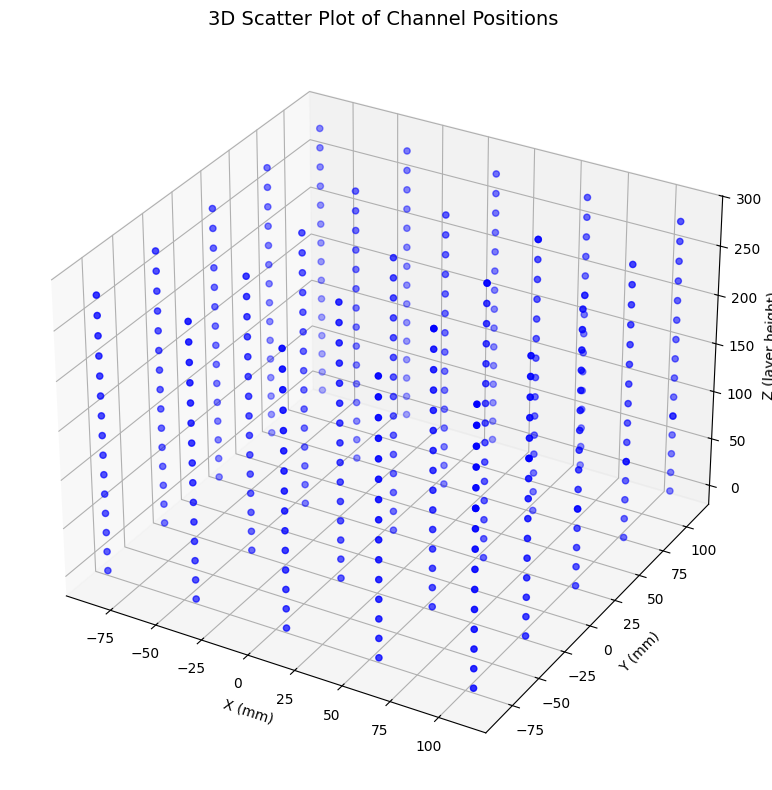

In [ ]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

# -------------------------------------------------------------------------------
#1. Set up for data
# -------------------------------------------------------------------------------

Data = {
    "Ch#": [],
    "Layer": [],
    "Assigned Slot": [],
    "x": [],
    "y": [],
    "z": [],
    "Position": [],
    "Board ID": [],
    "Date": []
} #Uses a dictionary Were the values will be saved (Ch# includes CAEN unit)

Channel_Numbers = [f"{board}-{ch_index}" for board in range(1, 7) for ch_index in range(64)]
#Sets up the range (6 units that has 63 channels)

# -------------------------------------------------------------------------------
#2. Coords set up
# -------------------------------------------------------------------------------

# X, Y grid used in the 3D plot
x_values = [109.800, 61.0, 12.2, -36.6, -85.4]
y_values = [109.800, 61.0, 12.2, -36.6, -85.4]

# Create all coordinate combinations
xy_pairs = list(itertools.product(x_values, y_values))

# Repeat Z-layers based on 15-layer system (like in tile code)
layer_mapping = {
    0: 0, 1: 20, 2: 40, 3: 60, 4: 80,
    5: 100, 6: 120, 7: 140, 8: 160, 9: 180,
    10: 200, 11: 220, 12: 240, 13: 260, 14: 280
}

# Fill positions for each channel, cycle through xy_pairs and layers for layout

lower_layer_mapping = {
    1: 0,
    2: 1,
    3: 5,
    4: 7,
    5: 10,
    6: 12
}
upper_layer_mapping = {
    1: 2,
    2: 3,
    3: 6,
    4: 8,
    5: 11,
    6: 13
}

position_cycle = itertools.cycle(xy_pairs)
position_values = {}

for ch in Channel_Numbers:
    board, ch_index = map(int, ch.split('-'))

    # Match the Z-layer based on tile positioning
    if 0 <= ch_index <= 12:
        layer = lower_layer_mapping[board]
    elif 13 <= ch_index <= 24:
        layer = lower_layer_mapping[board]
    elif 25 <= ch_index <= 37:
        layer = upper_layer_mapping[board]
    elif 38 <= ch_index <= 49:
        layer = upper_layer_mapping[board]
    elif 50 <= ch_index <= 63:
        if board in [1, 2]:
            layer = 4
        elif board in [3, 4]:
            layer = 9
        elif board in [5, 6]:
            layer = 14
    else:
        layer = 0  # default fallback

    x, y = next(position_cycle)
    z = layer_mapping[layer]
    position_values[ch] = (x, y, z)

# -------------------------------------------------------------------------------
#4. Board orientation
# -------------------------------------------------------------------------------

def board_position(board):
    return "Odd" if board % 2 == 1 else "Even"
#Checks to see if the board is in the top left or bottom right corner

# -------------------------------------------------------------------------------
#5. the meat of the code (Slots, layer and coords)
# -------------------------------------------------------------------------------

board_id_mapping = {
    1: "E1",
    2: "O1",
    3: "E2",
    4: "O2",
    5: "E3",
    6: "O3"

}


layer_counts = {i: 0 for i in range(15)}  # Track how many channels are assigned per layer
max_per_layer = 25

for ch in Channel_Numbers:
    #Get coords from other function
    x, y, z = position_values[ch]

    # Parse board and channel index from "board-ch_index"
    board, ch_index = map(int, ch.split('-'))

    # For channels 0-49, assign Assigned Slot and layer based on index ranges.
    if 0 <= ch_index <= 12:
        assigned_slot = "A"
        layer = lower_layer_mapping[board]
    elif 13 <= ch_index <= 24:
        assigned_slot = "B"
        layer = lower_layer_mapping[board]
    elif 25 <= ch_index <= 37:
        assigned_slot = "A"
        layer = upper_layer_mapping[board]
    elif 38 <= ch_index <= 49:
        assigned_slot = "B"
        layer = upper_layer_mapping[board]
    # For channels 50-63, use board parity to assign the slot:
    elif 50 <= ch_index <= 63:
        if board % 2 == 1:
            assigned_slot = "A"
        else:
            assigned_slot = "B"
        # And assign layer based on board group:
        if board in [1, 2]:
            layer = 4
        elif board in [3, 4]:
            layer = 9
        elif board in [5, 6]:
            layer = 14
    else:
        continue
    if layer_counts[layer] >= max_per_layer:
        continue
    x, y, z = position_values[ch]
    pos = board_position(board)

    board_id = board_id_mapping.get(board, "")
    today = datetime.today().strftime("%Y-%m-%d")

    # Add data to the dictionary
    Data["Ch#"].append(layer * 64 + ch_index)
    Data["Assigned Slot"].append(assigned_slot)
    Data["Layer"].append(layer)
    Data["x"].append(x)
    Data["y"].append(y)
    Data["z"].append(z)
    Data["Position"].append(pos)
    Data["Board ID"].append(board_id)
    Data["Date"].append(today)


# -------------------------------------------------------------------------------
# 6. Create DataFrame and Save It as a Pickle File
# -------------------------------------------------------------------------------

Geometry_df = pd.DataFrame(Data)
Geometry_df.to_pickle("geometry.pkl")
print("Geometry mapping saved to geometry.pkl")

# -------------------------------------------------------------------------------
#7 Create a plot using the x y and z values
#--------------------------------------------------------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(Geometry_df["x"], Geometry_df["y"], Geometry_df["z"], c='blue', marker='o', s=20)

# Labels and formatting
ax.set_title("3D Scatter Plot of Channel Positions", fontsize=14)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (layer height)")

plt.tight_layout()
plt.show()

Geometry mapping saved to geometry.pkl with 675 entries


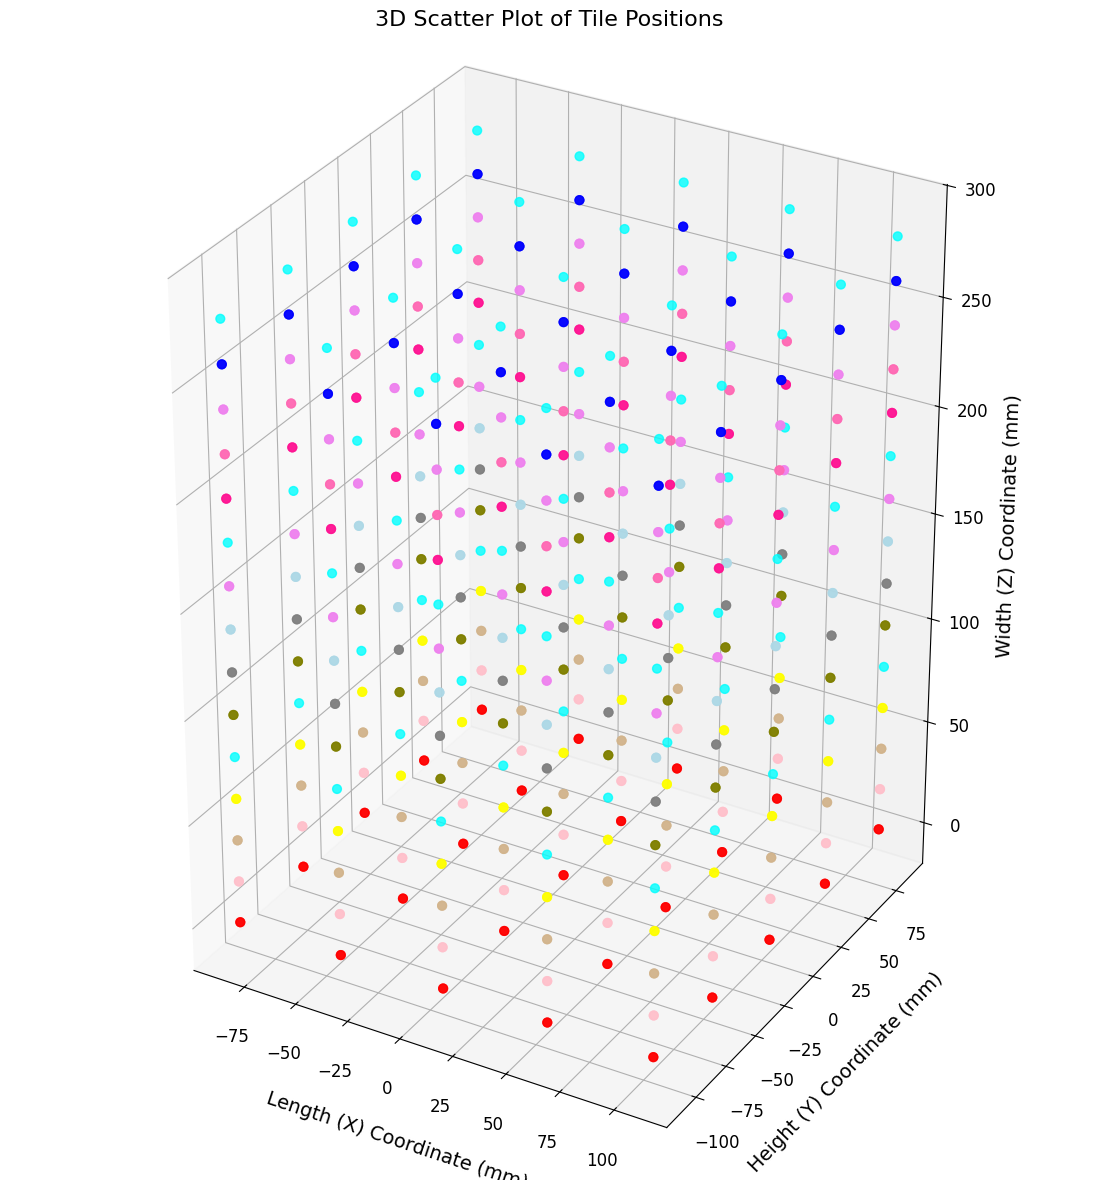

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 1. Set up data dictionary for TILE positions (not channels)
Tile_Data = {
    "Layer": [],
    "Assigned Slot": [],
    "x": [],
    "y": [],
    "z": [],
    "Position": [],
    "Color": []
}

# 2. Define coordinate system (Tile grid)
x_values = [109.800, 61.0, 12.2, -36.6, -85.4]
y_values = [109.800, 61.0, 12.2, -36.6, -85.4]

# 3. Corrected Z-layer mapping (15 unique layers)
layer_mapping = {
    0: 0, 1: 20, 2: 40, 3: 60, 4: 80,
    5: 100, 6: 120, 7: 140, 8: 160, 9: 180,
    10: 200, 11: 220, 12: 240, 13: 260, 14: 280
}

# 4. Board orientation function
def board_position(board):
    return "Odd" if board % 2 == 1 else "Even"

# 5. Define color mapping for each layer
color_mapping = {
    "0A": "red", "0B": "red",
    "1A": "pink", "1B": "pink",
    "4A": "cyan", "4B": "cyan", "9A": "cyan", "9B": "cyan", "14A": "cyan", "14B": "cyan",
    "2A": "tan", "2B": "tan",
    "3A": "yellow", "3B": "yellow",
    "5A": "olive", "5B": "olive",
    "6A": "grey", "6B": "grey",
    "7A": "lightblue", "7B": "lightblue",
    "8A": "violet", "8B": "violet",
    "10A": "deeppink", "10B": "deeppink",
    "11A": "hotpink", "11B": "hotpink",
    "12A": "violet", "12B": "violet",
    "13A": "blue", "13B": "blue"
}

# 6. Compute TILE positions (not individual channels)
for board in range(1, 7):
    # Determine which slots exist on this board
    slots = []
    if board in [1, 2, 3, 4, 5, 6]:
        slots.extend(["A", "B"])  # All boards have slots A and B

    for slot in slots:
        # Determine layer based on board and slot
        if slot == "A":
            if board == 1:
                layers = [0, 2, 4]
            elif board == 2:
                layers = [1, 3, 4]
            elif board == 3:
                layers = [5, 6, 9]
            elif board == 4:
                layers = [7, 8, 9]
            elif board == 5:
                layers = [10, 11, 14]
            elif board == 6:
                layers = [12, 13, 14]
        elif slot == "B":
            if board == 1:
                layers = [0, 2]
            elif board == 2:
                layers = [1, 3]
            elif board == 3:
                layers = [5, 6]
            elif board == 4:
                layers = [7, 8]
            elif board == 5:
                layers = [10, 11]
            elif board == 6:
                layers = [12, 13]

        for layer in layers:
            for x in x_values:
                for y in y_values:
                    z = layer_mapping[layer]
                    pos = board_position(board)
                    color_key = f"{layer}{slot}"

                    Tile_Data["Layer"].append(layer)
                    Tile_Data["Assigned Slot"].append(slot)
                    Tile_Data["x"].append(x)
                    Tile_Data["y"].append(y)
                    Tile_Data["z"].append(z)
                    Tile_Data["Position"].append(pos)
                    Tile_Data["Color"].append(color_mapping[color_key])

# 7. Create DataFrame and save
Geometry_df = pd.DataFrame(Tile_Data)
Geometry_df = Geometry_df.drop_duplicates(subset=["x", "y", "z", "Assigned Slot"])
Geometry_df.to_pickle("geometry.pkl")
print(f"Geometry mapping saved to geometry.pkl with {len(Geometry_df)} entries")

# 8. 3D Scatter Plot Visualization
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(111, projection='3d')

X = Geometry_df["x"]
Y = -Geometry_df["y"]  # Inverting y-axis for better visualization
Z = Geometry_df["z"]
colors = Geometry_df["Color"]

ax.scatter(X, Y, Z, c=colors, marker='o', alpha=0.8, s=40)

ax.set_xlabel("Length (X) Coordinate (mm)", fontsize=14, labelpad=20)
ax.set_ylabel("Height (Y) Coordinate (mm)", fontsize=14, labelpad=20)
ax.set_zlabel("Width (Z) Coordinate (mm)", fontsize=14, labelpad=20)
ax.set_title("3D Scatter Plot of Tile Positions", fontsize=16, pad=25)

ax.set_box_aspect([np.ptp(X), np.ptp(Y), np.ptp(Z)])
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.tick_params(axis='x', which='major', pad=10, labelsize=12)
ax.tick_params(axis='y', which='major', pad=10, labelsize=12)
ax.tick_params(axis='z', which='major', pad=10, labelsize=12)

plt.show()